# DB-SCAN - Density-based spatial clustering of applications with noise 

DBSCAN groups together points that are close to each other and a minimum number of points. It also marks as outliers as points that are in low-density regions.

DBSCAN creates a circle of epsilon radius around every data point and classifies them into Core point, Border point, and Noise. A data point is a Core point if the circle around it contains at least ‘minPoints’ number of points. If the number of points is less than minPoints but contains a Core point, then it is classified as Border Point, and if there are no Core points around, then it treated as Noise.


The DBSCAN algorithm requires 2 parameters:<br>
Epsilon: States how close together points need to be in order to be considered a part of a cluster. <br>
Minimum amount of Points: States the minimum number of points to form a dense region (aka: cluster).<br>

For a more in technical definition see [wikipedia.](https://en.wikipedia.org/wiki/DBSCAN)

In [1]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

## Implement DBscan from scratch

In [2]:
# minPts are given and are not required to be estimated.
minPts = 50 

class DBscan:
    
    def __init__(self, epsilon, min_pts):
        '''
        epsilon: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_pts: The number of points in a neighborhood for a point to be considered as a core point. This includes the point itself.
        '''
        self.min_pts = min_pts
        self.epsilon = epsilon
        
    def fit_predict(self, X):
        '''
        Perform DBSCAN clustering from features or distance matrix, and return cluster labels.
        X: matrix of coodinates for data points
        '''
        visited = np.zeros(X.shape[0], dtype=bool)
        clusters = np.zeros(X.shape[0])
        cluster_num = 0
        # for every x in X
        for idx, row in enumerate(X):
            
            # If visited continue, else mark as visited
            if visited[idx]:
                continue
            else:
                visited[idx] = True
                
            # Now we need to get neighbors
            neighbors_idxs = np.argwhere(cdist(np.expand_dims(row, axis=0), X) <= self.epsilon)
            # if this point is a core point
            if neighbors_idxs.shape[0] >= self.min_pts:
                cluster_num += 1
                clusters[neighbors_idxs[:,1]] = cluster_num
                neighbors_idxs = list(neighbors_idxs)
                
                while neighbors_idxs:
                    pnt = neighbors_idxs.pop()
                    if ~visited[pnt[1]]:
                        visited[pnt[1]] = True
                        new_neighbors_idxs = np.argwhere(cdist(np.expand_dims(X[pnt[1]], axis=0), X) <= self.epsilon)
                        if new_neighbors_idxs.shape[0] >= self.min_pts:
                            neighbors_idxs +=  list(new_neighbors_idxs)
                    if clusters[pnt[1]] == 0:
                        clusters[pnt[1]] = cluster_num
                        
            else:
                clusters[idx] = -1
        return clusters


### Lets generate some random cluster data

In [3]:
# auxilary plotting functions
def plot(X):
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()

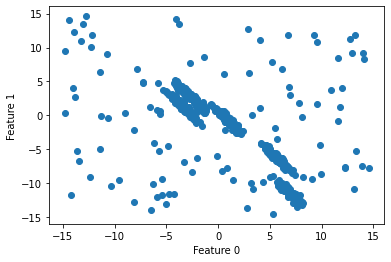

In [4]:
X, y = make_blobs(random_state=170, n_samples=500, centers = 5)
rng = np.random.RandomState(74)
# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

# Adding Noise to data
outliers = 30 * (np.random.RandomState(42).rand(100, 2) ) - 15.0
X = np.concatenate([X, outliers])
y = np.concatenate([y, [-1]*len(outliers)])

plot(X)

### Estimateing $\varepsilon$

Here we go over different eps values and find the one that maximizes the silhouette value.
We implement the following algorithm to find the best $\epsilon$ using this method.
1. Create an array of possible $\epsilon$ values.
2. Iterate over the different values and find the best $\epsilon$ value. What is it?
3. Visualize the results of the best one.

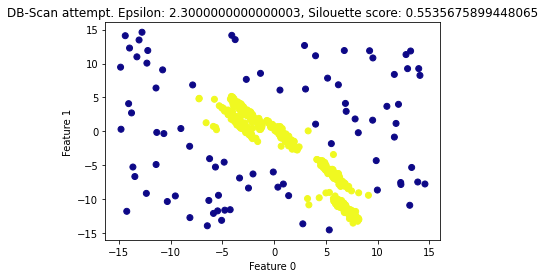

Max value of silouette score is 0.5535675899448065


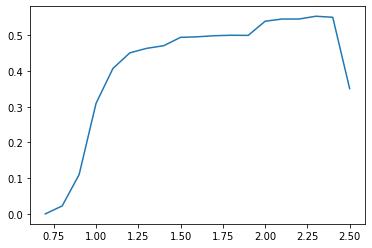

In [5]:
epsilons = [k*0.1 for k in range(7, 26)]
sv_list = []

for epsilon in epsilons:
    db = DBscan(epsilon, minPts)
    db_clusters = db.fit_predict(X)
    if db_clusters.min() == db_clusters.max():
        sv_list.append(0)
    else:
        sv_list.append(silhouette_score(X, db_clusters))
    
plt.scatter(X[:, 0], X[:, 1], c=db_clusters, cmap="plasma") 
plt.title(f"DB-Scan attempt. Epsilon: {epsilons[np.argmax(np.array(sv_list))]}, Silouette score: {max(sv_list)}")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

print(f'Max value of silouette score is {max(sv_list)}')
plt.plot(epsilons, sv_list)
plt.show()

#### Lets support our findings by plotting the _k-distance_ graph of the data with our $minPts$, and repeat the above process with a more precise range of $\epsilon$. 

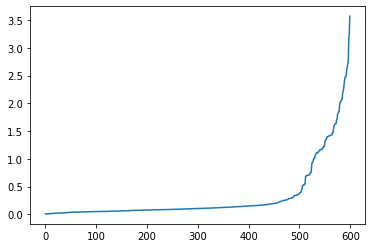

In [6]:
# Here we find an epsilon according to the k-dist graph

def plotKDist(data, numNeighbours=2):
    neigh = NearestNeighbors(n_neighbors=numNeighbours)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.show()
    
plotKDist(X, 2)

### We repeat process with a much smaller range around the epsilon we found via k-dist graph and visualize the results
We can see that the elbow of our graph is at about 0.5. Lets search for epsilons in the area immediately around 0.5

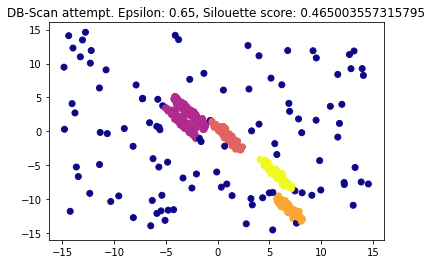

Max value of silouette score is 0.465003557315795


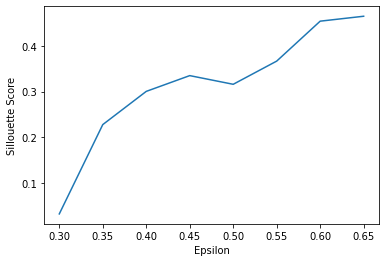

In [7]:
epsilons = [k*0.05 for k in range(6, 14)]
sv_list = []

for epsilon in epsilons:
    db = DBscan(epsilon, 10)
    db_clusters = db.fit_predict(X)
    
    if db_clusters.min() == db_clusters.max():
        sv_list.append(0)
    else:
        sv_list.append(silhouette_score(X, db_clusters))
    
plt.scatter(X[:, 0], X[:, 1], c=db_clusters, cmap="plasma") 

plt.title(f"DB-Scan attempt. Epsilon: {epsilons[np.argmax(np.array(sv_list))]}, Silouette score: {max(sv_list)}")
plt.show()

print(f'Max value of silouette score is {max(sv_list)}')
plt.plot(epsilons, sv_list)
plt.xlabel("Epsilon")
plt.ylabel("Sillouette Score")
plt.show()

We can see that indeed out results improved because we were able to search a smaller area for optimal parameters.